In [155]:
import os
import re

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D
from gensim.models import Word2Vec
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
import seaborn as sns
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib import colors

import config


In [2]:
w2v_path = os.path.join("word_embedding", "ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz")
hh_data_path = os.path.join("headHunter_data", "hh_dataset.csv")

In [3]:
dataset_hh = pd.read_csv(hh_data_path, sep="\t")

In [4]:
dataset_hh.head()

,id,lang_title,requirement,requirement_lemmas,requirement_lemmas_tags,requirement_norm,requirement_tokens,responsibility,responsibility_lemmas,responsibility_lemmas_tags,...,title_tokens,url,lang_text,profarea_names,specializations,text,text_lemmas,text_lemmas_tags,text_normalized,text_tokens
0,29103667,russian,Высшее (желательно техническое) образование. П...,высший желательный технический образование lot...,высший_ADJ желательный_ADJ технический_ADJ обр...,высш желательн техническ образован lotus хорош...,высшее желательно техническое образование lotu...,Ежедневное планирование работы завода (молочно...,ежедневный планирование работа завод молочный ...,ежедневный_ADJ планирование_NOUN работа_NOUN з...,...,специаидать_NOUN планирование_NOUN производств...,https://api.hh.ru/vacancies/29103667?host=hh.ua,russian,"['Производство', 'Закупки']","['Пищевая промышленность', 'Управление закупка...",<p><strong>Международная компания – крупнейший...,международный компания крупнейший производител...,международный_ADJ компания_NOUN крупнейший_ADJ...,международн компан крупн производител свеж мол...,международный_ADJ компания_NOUN крупнейший_ADJ...
1,29103666,russian,Умение работать в коллективе. Образование не н...,умение работать коллектив образование ниже тех...,умение_NOUN работать_VERB коллектив_NOUN образ...,умен работа коллектив образован ниж техническ ...,умение работать коллективе образование ниже те...,Техническая подготовка выполнения сварочных ра...,технический подготовка выполнение сварочный ра...,технический_ADJ подготовка_NOUN выполнение_NOU...,...,главный_ADJ сварщик_NOUN,https://api.hh.ru/vacancies/29103666?host=hh.ua,russian,['Рабочий персонал'],['Сварщик'],<strong>Обязанности:</strong> <ul> <li><em>Тех...,обязанность технический подготовка выполнение ...,обязанность_NOUN технический_ADJ подготовка_NO...,обязан техническ подготовк выполнен сварочн ра...,обязанность_NOUN технический_ADJ подготовка_NO...
2,29103665,russian,At least a bachelor degree in Computer Science...,least bachelor degree computer science master ...,least bachelor degree computer science master ...,least bachelor degre comput scienc master degr...,least bachelor degree computer science master ...,Contributes to product and performance improve...,contributes product performance improvement op...,contributes product performance improvement op...,...,java_X developer_X,https://api.hh.ru/vacancies/29103665?host=hh.ua,english,"['Информационные технологии, интернет, телеком']","['Программирование, Разработка']",<p>Role:<br />Contributes to product and perfo...,role contributes product performance improveme...,role contributes product performance improveme...,role contribut product perform improv optim ex...,role contributes product performance improveme...
3,29103664,russian,Профильное высшее образование (Художественное/...,профильный высший образование креативность нес...,профильный_ADJ высший_ADJ образование_NOUN кре...,профильн высш образован креативн нестандартн м...,профильное высшее образование креативность нес...,Дизайн и верстка еженедельного акционного букл...,дизайн верстка еженедельный акциоть буклет раз...,дизайн_NOUN верстка_NOUN еженедельный_ADJ акци...,...,дизайнер_NOUN,https://api.hh.ru/vacancies/29103664?host=hh.ua,russian,"['Искусство, развлечения, масс-медиа', 'Маркет...","['Дизайн, графика, живопись', 'Дизайнер']",<p><strong>Сеть гипермаркетов ProStore приглаш...,сеть гипермаркет prostore приглашать постоянны...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...,сет гипермаркет prostor приглаша постоя работ ...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...
4,29103661,russian,1. Высшее образование ( в приоритете: менеджме...,высший образование приоритет менеджмент маркет...,высший_ADJ образование_NOUN приоритет_VERB мен...,высш образован приоритет менеджмент маркетинг ...,высшее образование приоритете менеджмент марке...,Наша студия помогает компаниям повышать продаж...,наш студия помогать компания повышать продажа ...,наш_DET студия_N

In [5]:
dataset_hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 26 columns):
id                            3653 non-null int64
lang_title                    3653 non-null object
requirement                   3536 non-null object
requirement_lemmas            3536 non-null object
requirement_lemmas_tags       3536 non-null object
requirement_norm              3536 non-null object
requirement_tokens            3536 non-null object
responsibility                3472 non-null object
responsibility_lemmas         3472 non-null object
responsibility_lemmas_tags    3472 non-null object
responsibility_norm           3472 non-null object
responsibility_tokens         3472 non-null object
title                         3653 non-null object
title_lemmas                  3335 non-null object
title_lemmas_tags             3335 non-null object
title_normalized              3335 non-null object
title_tokens                  3335 non-null object
url                        

### Prapare data to rnn

In [6]:
vectorizer = KeyedVectors.load_word2vec_format(w2v_path, binary=False)


In [141]:
labels = []
for i, row in dataset_hh.iterrows():
    specs = row["profarea_names"].lower()
    specs = specs.split("', ") 
    for spec in specs: 
        spec = re.sub('[\[\'\]]', '', spec)
        labels.append(spec.strip())

labels = list(set(labels))

In [142]:
print("Labels number:", len(labels))
print("Labels:", labels)

Labels number: 28
Labels: ['государственная служба, некоммерческие организации', 'наука, образование', 'медицина, фармацевтика', 'домашний персонал', 'безопасность', 'инсталляция и сервис', 'страхование', 'продажи', 'консультирование', 'бухгалтерия, управленческий учет, финансы предприятия', 'искусство, развлечения, масс-медиа', 'управление персоналом, тренинги', 'спортивные клубы, фитнес, салоны красоты', 'транспорт, логистика', 'автомобильный бизнес', 'информационные технологии, интернет, телеком', 'начало карьеры, студенты', 'туризм, гостиницы, рестораны', 'маркетинг, реклама, pr', 'добыча сырья', 'высший менеджмент', 'административный персонал', 'производство', 'банки, инвестиции, лизинг', 'юристы', 'строительство, недвижимость', 'рабочий персонал', 'закупки']


In [17]:
def vectorize_text(text, vectorizer, max_len):
    """
    :param str text: normalized text
    :param Word2Vec vectorizer:
    :param int max_len:
    :return np.array text_vect: of shape like (1, max_len, 100)
    """
    text_vect = []
    words = text.split(" ")
    for word in words:
        try:
            word_vect = vectorizer.word_vec(word)
            text_vect.append(word_vect)
        except KeyError:
            None
      
    np.array(text_vect)
    text_vect = np.reshape(text_vect, (1, -1, 100))
    text_vect = sequence.pad_sequences(text_vect, maxlen=max_len, dtype='float')
            
    return text_vect
    

In [24]:

n_classes = len(labels)
n_examples = len(dataset_hh)
X = []
Y = np.zeros((n_examples, n_classes))
for i, row in dataset_hh.iterrows():
    X.append([])
    words = row["text_lemmas_tags"].split(" ")
    for word in words:
        try:
            word_vec = vectorizer.word_vec(word)
            X[i].append(word_vec)
        except KeyError:
            None
    
    specs = row["profarea_names"].lower() 
    specs = specs.split("', ") 
    for spec in specs: 
        spec = re.sub('[\[\'\]]', '', spec)
        pos = labels.index(spec.strip())
        Y[i][pos] = 1
        
assert(len(X) == len(Y))


In [28]:
max_len = max([len(i) for i in X])
print("Max len =", max_len)

Max len = 689


In [30]:
max_len = 300
print("Max len edited=", max_len)

Max len edited= 300


In [33]:
X = sequence.pad_sequences(X, maxlen=max_len, dtype='float')
X = np.array(X)


In [34]:
print(X.shape)
print(Y.shape)

(3653, 300, 300)
(3653, 28)


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2922, 300, 300)
(731, 300, 300)


In [63]:
print(Y_train.shape)
print(Y_test.shape)

(2922, 28)
(731, 28)


In [36]:
del X
del Y

In [37]:
def get_classes(y_one_hot, labels, threshold=0.5):
    """
    :param np.array y_one_hot: shape like (1, n_classes)
    :param list of str labels:
    :return list of str classes: 
    """
    classes = []
    y_rounded = np.zeros(y_one_hot.shape)
    y_rounded[y_one_hot > threshold] = 1
    for i in range(len(labels)):
        if y_rounded[0][i] == 1:
            classes.append(labels[i])
            
    return classes
        

In [143]:
counts = []
for i in range(len(labels)):
    print(' Species {} appears {} times'.format(labels[i], np.sum(Y_train[:,i]) + np.sum(Y_test[:,i])))
    counts.append(np.sum(Y_train[:,i]) + np.sum(Y_test[:,i]))
print('###')
all_y = np.concatenate([Y_train, Y_test])
all_sum_y = np.sum(all_y, axis=1)
print('As a mean {} species appear on each recording (standard deviation {})'.format(np.mean(all_sum_y), np.std(all_sum_y)))

 Species государственная служба, некоммерческие организации appears 6.0 times
 Species наука, образование appears 62.0 times
 Species медицина, фармацевтика appears 134.0 times
 Species домашний персонал appears 35.0 times
 Species безопасность appears 28.0 times
 Species инсталляция и сервис appears 25.0 times
 Species страхование appears 37.0 times
 Species продажи appears 1415.0 times
 Species консультирование appears 233.0 times
 Species бухгалтерия, управленческий учет, финансы предприятия appears 200.0 times
 Species искусство, развлечения, масс-медиа appears 95.0 times
 Species управление персоналом, тренинги appears 95.0 times
 Species спортивные клубы, фитнес, салоны красоты appears 78.0 times
 Species транспорт, логистика appears 283.0 times
 Species автомобильный бизнес appears 127.0 times
 Species информационные технологии, интернет, телеком appears 519.0 times
 Species начало карьеры, студенты appears 934.0 times
 Species туризм, гостиницы, рестораны appears 290.0 times
 S

In [144]:
counts

[6.0,
 62.0,
 134.0,
 35.0,
 28.0,
 25.0,
 37.0,
 1415.0,
 233.0,
 200.0,
 95.0,
 95.0,
 78.0,
 283.0,
 127.0,
 519.0,
 934.0,
 290.0,
 316.0,
 8.0,
 57.0,
 552.0,
 211.0,
 303.0,
 58.0,
 275.0,
 154.0,
 46.0]

In [145]:
counts[15]

519.0

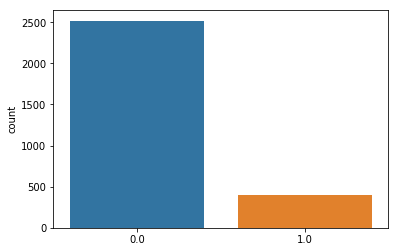

In [114]:
sns.countplot(Y_train[:, 15])

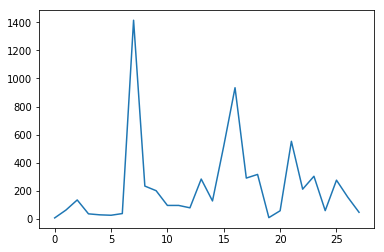

In [146]:
plt.plot(counts)

In [147]:
Y1 = Y_train[:, 15]
Y1.shape

(2922,)

In [151]:
indexes = []
labels_new = []
counts_new = []

for i in range(len(labels)):
    if counts[i] > 50:
        labels_new.append(labels[i])
        counts_new.append(counts[i])
        indexes.append(i)
        
Y_train = Y_train[:, indexes]

In [152]:
print(len(labels_new))
print(labels_new)
print()
print(counts_new)

21
['наука, образование', 'медицина, фармацевтика', 'продажи', 'консультирование', 'бухгалтерия, управленческий учет, финансы предприятия', 'искусство, развлечения, масс-медиа', 'управление персоналом, тренинги', 'спортивные клубы, фитнес, салоны красоты', 'транспорт, логистика', 'автомобильный бизнес', 'информационные технологии, интернет, телеком', 'начало карьеры, студенты', 'туризм, гостиницы, рестораны', 'маркетинг, реклама, pr', 'высший менеджмент', 'административный персонал', 'производство', 'банки, инвестиции, лизинг', 'юристы', 'строительство, недвижимость', 'рабочий персонал']

[62.0, 134.0, 1415.0, 233.0, 200.0, 95.0, 95.0, 78.0, 283.0, 127.0, 519.0, 934.0, 290.0, 316.0, 57.0, 552.0, 211.0, 303.0, 58.0, 275.0, 154.0]


In [161]:
classes_weights = []
max_count = max(counts_new)
for i in range(len(counts_new)):
    weight = max_count / counts_new[i] 
    classes_weights.append(weight)

classes_weights = [classes_weights]  
print(classes_weights) 
print(len(classes_weights))

[[22.822580645161292, 10.559701492537313, 1.0, 6.072961373390558, 7.075, 14.894736842105264, 14.894736842105264, 18.141025641025642, 5.0, 11.141732283464567, 2.7263969171483624, 1.5149892933618843, 4.879310344827586, 4.477848101265823, 24.82456140350877, 2.5634057971014492, 6.706161137440758, 4.66996699669967, 24.396551724137932, 5.1454545454545455, 9.188311688311689]]
1


### Training

In [90]:
sample_weight = np.ones(Y1.shape)
sample_weight[Y1 == 1] = 5
print(len(sample_weight[sample_weight==5]))

404


In [153]:
Y_train.shape

(2922, 21)

In [157]:
len(labels_new)

21

In [162]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, padding= 'same',
                 activation="relu", input_shape=(max_len, 300)))
model.add(Conv1D(filters=32, kernel_size=3, padding= 'same',
                 activation="relu"))
model.add(MaxPooling1D(pool_size=2))

#model.add(LSTM(10))
model.add(Bidirectional(layer=LSTM(50, dropout=0.3, recurrent_dropout=0.3),
                        input_shape=(max_len, 300)))
model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(len(labels_new), activation="sigmoid", kernel_regularizer=l2(0.1)))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"],
              loss_weights=classes_weights)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 300, 32)           28832     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100)               33200     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 21)                1071      
Total para

In [164]:
%%time
model.fit(X_train, Y_train,
          batch_size=64, 
          epochs=3,
          validation_split=0.15,
          verbose=1)


Train on 2483 samples, validate on 439 samples
Epoch 1/3
2483/2483 [==============================] - 51s 21ms/step - loss: 12.7243 - acc: 0.7800 - val_loss: 8.6945 - val_acc: 0.9165
Epoch 2/3
2483/2483 [==============================] - 32s 13ms/step - loss: 7.9821 - acc: 0.8856 - val_loss: 6.1225 - val_acc: 0.9165
Epoch 3/3
2483/2483 [==============================] - 64s 26ms/step - loss: 5.8040 - acc: 0.9028 - val_loss: 4.6906 - val_acc: 0.9165
Wall time: 2min 30s


In [170]:
np.round(model.predict(X_train[0].reshape((1, -1, 300))))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)

In [169]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [171]:
predict = model.predict(X_train)

In [172]:
np.round(predict[:10])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [173]:
np.sum(np.round(predict))

0.0

In [ ]:
%%time
scores = model.evaluate(X_test, Y_test, batch_size=64)
print("Test accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:

classif_list = []
train_score_list, test_score_list = [], []

# Training
for i in range(len(labels)):
    y_train_for_label = Y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_label)
    classif_list.append(new_classifier)

### Test

In [ ]:
# Test & display results
for i in range(len(birds_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(birds_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(birds_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))
